$$\max_{\textbf{w}}Sharpe(\textbf{w})=\frac{\textbf{w}^T(\mu-r_f)}{\sqrt{\textbf{w}^T\Sigma\textbf{w}}}$$
$$\text{s.t }\sum\textbf{w}=1$$

In [10]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [14]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
data = yf.download(tickers, start="2020-01-01", end="2024-12-31")['Close']


returns = np.log(data / data.shift(1)).dropna()


mean_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252
rf = 0.045

[*********************100%***********************]  4 of 4 completed


In [15]:
def portfolio_stats(weights, returns, cov, rf):
    port_return = np.dot(weights, returns)
    port_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    sharpe = (port_return - rf) / port_std
    return port_return, port_std, sharpe

def neg_sharpe_ratio(weights, returns, cov, rf):
    return -portfolio_stats(weights, returns, cov, rf)[2]

In [16]:
n_assets = len(tickers)
init_guess = np.ones(n_assets) / n_assets
bounds = tuple((0, 1) for _ in range(n_assets))
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

opt_result = minimize(neg_sharpe_ratio, init_guess,
                      args=(mean_returns, cov_matrix, rf),
                      method='SLSQP', bounds=bounds,
                      constraints=constraints)

opt_weights = opt_result.x
opt_return, opt_std, opt_sharpe = portfolio_stats(opt_weights, mean_returns, cov_matrix, rf)

print("=== Optimal Portfolio ===")
for ticker, weight in zip(tickers, opt_weights):
    print(f"{ticker}: {weight:.2%}")
print(f"Expected return: {opt_return:.2%}")
print(f"Volatility: {opt_std:.2%}")
print(f"Sharpe Ratio: {opt_sharpe:.2f}")

=== Optimal Portfolio ===
AAPL: 80.69%
MSFT: 0.00%
GOOGL: 18.42%
AMZN: 0.90%
Expected return: 24.11%
Volatility: 30.03%
Sharpe Ratio: 0.65


In [18]:
num_portfolios = 100_000
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    weights = np.random.random(n_assets)
    weights /= np.sum(weights)
    weights_record.append(weights)

    port_return = np.dot(weights, mean_returns)
    port_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = (port_return - rf) / port_std

    results[0, i] = port_return
    results[1, i] = port_std
    results[2, i] = sharpe

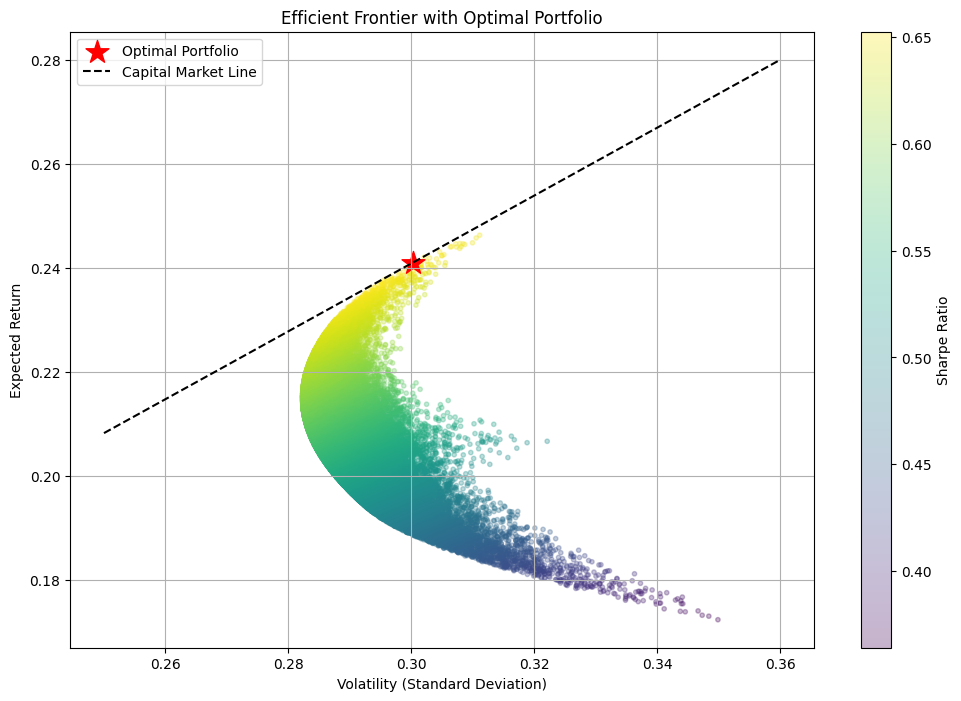

In [19]:
plt.figure(figsize=(12, 8))
sc = plt.scatter(results[1], results[0], c=results[2], cmap='viridis', marker='o', s=10, alpha=0.3)
plt.colorbar(sc, label='Sharpe Ratio')

plt.scatter(opt_std, opt_return, marker='*', color='r', s=300, label='Optimal Portfolio')
x_vals = np.linspace(0.25, 0.36, 100)
cml = rf + opt_sharpe * x_vals
plt.plot(x_vals, cml, linestyle='--', color='black', label='Capital Market Line')
plt.title('Efficient Frontier with Optimal Portfolio')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()